## Bayesian Evidence
In this notebook I will use the posterior estimate to estimate the evidence.
$$ \frac{\mathcal{P}(\theta)}{\Pi(\theta)\mathcal{L}(\theta)} = \mathcal{E} $$
$$ \log(\mathcal{P}(\theta)) - \log(\Pi(\theta)) - \log(\mathcal{L}(\theta)) = \log(\mathcal{E}) $$
The posterior will be estimated using normalizing flows. The evidence will be approximated two ways:
1. On a dense grid. This tells us if the evidence is well approximated in the entire parameter space
2. For each sample. This tells us if the evidence is well approximated in the highly populated regions of the parameter space.
The evidence will be approximated as a function of chain length.

In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import getdist
from getdist import plots, MCSamples, WeightedSamples

import sys
import datetime 
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2
import emcee

# Now normalizing flow
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

from numpy import linalg
import scipy

%matplotlib inline

In [9]:
### open the long chain
filename = "/home/grads/ownCloud/StatisticalProject/chains/godzilla.h5"
reader = emcee.backends.HDFBackend(filename, read_only=True)

#all samples
samples = reader.get_chain(flat=True)
#remove burn in and thin
samples_thin = reader.get_chain(flat=True, thin=1000, discard=5000)

In [24]:
# create an array of chain lengths:
chain_lengths = [100,500,1000,5000,10000,20000,30000,40000,50000,75000,100000,125000,250000,500000]

Lets do a single chain length as an example first.

In [34]:
### LSST EMULATOR FUNCTIONS
def add_bias(bias_theta, datavector):
    for i in range(5):
        factor = (bias_theta[i] / bias_fid[i])**bias_mask[i]
        datavector = factor * datavector
    return datavector

def add_shear_calib(m, datavector):
    for i in range(5):
        factor = (1 + m[i])**shear_calib_mask[i]
        datavector = factor * datavector
    return datavector

def hard_prior(theta, params_prior):
    """
    A function to impose a flat prior on a set of parameters.
    :theta: The set of parameter values
    :params_prior: The minimum and the maximum value of the parameters on which this prior is imposed
    """
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
cosmo_prior_lim = np.array([[1.61, 3.91],
                       [0.87, 1.07],
                       [55, 91],
                       [0.01, 0.04],
                       [0.001, 0.99]])

ia_prior_lim = np.array([[-5., 5.],
                       [-5., 5.]])

bias_prior_lim = np.array([[0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.]])

baryon_prior_lim = np.array([[-3., 12.],
                             [-2.5, 2.5]])

baryon_prior_lim = 3. * baryon_prior_lim 

dz_source_std   = 0.002 * np.ones(5)
dz_lens_std     = 0.005 * np.ones(5)
shear_calib_std = 0.005 * np.ones(5)
    
def lnprior(theta):
    cosmo_theta = theta[:5]
    ns          = cosmo_theta[1]

    ns_prior    = 0.
    
    dz_source   = theta[5:10]
    ia_theta    = theta[10:12]
    dz_lens     = theta[12:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    
    cosmo_prior = hard_prior(cosmo_theta, cosmo_prior_lim) + ns_prior
    ia_prior    = hard_prior(ia_theta, ia_prior_lim)
    bias_prior  = hard_prior(bias, bias_prior_lim)
    baryon_prior = hard_prior(baryon_q, baryon_prior_lim)
    
    dz_source_lnprior   = -0.5 * np.sum((dz_source / dz_source_std)**2)
    dz_lens_lnprior     = -0.5 * np.sum((dz_lens / dz_lens_std)**2)
    shear_calib_lnprior = -0.5 * np.sum((shear_calib / shear_calib_std)**2)
    
    return cosmo_prior + ia_prior + dz_source_lnprior + dz_lens_lnprior + \
            shear_calib_lnprior + bias_prior + baryon_prior
    
def ln_lkl(theta):
    model_datavector = get_data_vector_emu(theta)[0]
    delta_dv = (model_datavector - data_model.dv_obs)[data_model.mask_3x2]
    return -0.5 * delta_dv @ data_model.masked_inv_cov @ delta_dv

def lnprob(theta):
    return lnprior(theta) + ln_lkl(theta)

def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    return datavector

### Get the necessary data for likelihood

# Get the LSST covariance and fid data
path = '/home/grads/data/evan/LSST_emulation/data/lsst_y1/'
lsst_cov = np.loadtxt(path+'cov_lsst_y1')
fid_cos = np.loadtxt(path+'lsst_y1_data_fid',dtype=np.float32)[:,1]

lsst_y1_cov = np.zeros((1560, 1560))
for line in lsst_cov:
    i = int(line[0])
    j = int(line[1])

    cov_g_block  = line[-2]
    cov_ng_block = line[-1]

    cov_ij = cov_g_block + cov_ng_block

    lsst_y1_cov[i,j] = cov_ij
    lsst_y1_cov[j,i] = cov_ij
    
fid = torch.Tensor(fid_cos)
cov = torch.Tensor(lsst_y1_cov)

# Code taken from the emulator notebook
#first the fiducial cosmology

configfile = 'configs/nn_emu.yaml'
config = Config(configfile)

config_args     = config.config_args
config_args_io  = config_args['io']
config_args_data = config_args['data']

savedir = 'output/nn_emu/'

N_DIM         = 17
data_model    = LSST_3x2(N_DIM, config_args_io, config_args_data)
data_model.emu_type = 'nn'
OUTPUT_DIM = 1560

emu = NNEmulator(N_DIM, OUTPUT_DIM, data_model.dv_fid, data_model.dv_std)    
emu.load('model/nn_emu/model')
# ======================================================

data_model.emu = emu

bias_fid         = data_model.bias_fid
bias_mask        = data_model.bias_mask
shear_calib_mask = data_model.shear_calib_mask

In [12]:
# Compute value at each sample
length_eg = samples[:100]
prior_lkl = np.array([lnprob(s) for s in length_eg])
print(len(prior_lkl))

100


In [13]:
### NORMALIZING FLOW FUNCTIONS

class Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self._loss = []
        self._epoch = []
        self.n_epochs = self.params['epochs']
        print('[                    ] Training... ',end="")
        
    def on_epoch_begin(self, epoch, logs=None):
        progress = int(epoch/self.n_epochs*20)
        ret = '\r['
        for i in range(progress):
            ret += '#'
        for i in range(20-progress):
            ret += ' '
        print(ret+'] Training... (epoch {}/{})'.format(epoch,self.n_epochs),end="")

    def on_epoch_end(self, epoch, logs=None):
        self._loss.append(logs['loss'])
        self._epoch.append(epoch)

    def on_train_end(self, logs=None):
        print('\r'+'[####################] Completed!                          ')
        fig,ax1 = plt.subplots(1,1)
        
        ax1.set_title('loss vs. epoch')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(self._epoch,self._loss)
        
class No_Plot_Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.n_epochs = self.params['epochs']
        print('[                    ] Training... ',end="")
        
    def on_epoch_begin(self, epoch, logs=None):
        progress = int(epoch/self.n_epochs*20)
        ret = '\r['
        for i in range(progress):
            ret += '#'
        for i in range(20-progress):
            ret += ' '
        print(ret+'] Training... (epoch {}/{})'.format(epoch,self.n_epochs),end="")

    def on_train_end(self, logs=None):
        print('\r'+'[####################] Completed!                             ')

def pregauss(chain,data):
    covmat = chain.cov().astype(np.float32)
    mean = chain.getMeans().astype(np.float32)
    
    # bijector time!
    # TriL means the cov matrix is lower triangular. Inverse is easy to compute that way
    # the cholesky factorization takes a positive definite hermitian matrix M (like the covmat) to LL^T with L lower triangluar
    gauss_approx = tfd.MultivariateNormalTriL(loc=mean,scale_tril=tf.linalg.cholesky(covmat))
    bijector = gauss_approx.bijector

    # now map the data
    new_data = bijector.inverse(data.astype(np.float32))
    return new_data,bijector

def train(base,data,bijectors,batch_size,n_epochs,feedback=True):
    val_split = 0.1
    # stack data
    _data = []
    dim = 0
    for key in data.getParamNames().list():
        nsamples=len(data[key])
        _data.append(data[key])
        dim += 1

    xdata = np.stack(_data, axis=-1)

    x_data,bij = pregauss(data,xdata)

    #create data set with weights.
    weights = data.weights.astype(np.float32)
    
    ## NN setup
    target_distribution = tfd.TransformedDistribution(
        distribution=base,
        bijector=tfb.Chain(bijectors)) 

    # Construct model.
    x_ = tfk.Input(shape=(dim,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  loss=lambda _, log_prob: -log_prob) 
    if(feedback):
        print('---   Model compiled   ---')
        print(" - N samples = {}".format(nsamples))
        if weights.all()==weights[0]:
            print(" - Uniform weights = {}".format(weights[0]))
        else:
            print(" - Non-uniform weights")
        print(" - Pre-Gaussian Map = True\n")
        print(" - Validation split = {}".format(val_split))
        print(' - Number MAFS = {} '.format(int(len(bijectors)/2)))
        print(' - Trainable parameters = {} \n'.format(model.count_params()))

    # now perform the fit
    if(feedback):
        model.fit(x=x_data,
                  y=np.zeros((nsamples, dim),dtype=np.float32),
                  batch_size=batch_size,
                  epochs=n_epochs,
                  steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
                  validation_split=val_split,
                  shuffle=True,
                  verbose=False,
                  callbacks=[Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
    if(not feedback):
        model.fit(x=x_data,
                  y=np.zeros((nsamples, dim),dtype=np.float32),
                  batch_size=batch_size,
                  epochs=n_epochs,
                  steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
                  validation_split=val_split,
                  shuffle=True,
                  verbose=False,
                  callbacks=[No_Plot_Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
        
    return(target_distribution,bij)

def setup(n_maf,n_params,permute,feedback=True):
    # Set up bijector MADE
    hidden_units=[n_params*2]*2
    if(feedback):
        print('---   MADE Info   ---')
        print(' - Hidden_units = {}'.format(hidden_units))
        print(' - Activation = {}\n'.format(tf.math.asinh))
    bijectors=[]
    if(permute==True):
        _permutations = [np.random.permutation(n_params) for _ in range(n_maf)]
    else:
        _permutations=False
    
    for i in range(n_maf):
        # the permutation part comes from the code M. Raveri wrote,
        if _permutations:
            #print(_permutations[i])
            bijectors.append(tfb.Permute(_permutations[i].astype(np.int32)))
        # rest by myself
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, event_shape=(n_params,), hidden_units=hidden_units, activation=tf.math.asinh, kernel_initializer='glorot_uniform')))
        
    return bijectors

Removed no burn in
---   MADE Info   ---
 - Hidden_units = [10, 10]
 - Activation = <function asinh at 0x7f639ed5b200>

---   Model compiled   ---
 - N samples = 100
 - Uniform weights = 1.0
 - Pre-Gaussian Map = True

 - Validation split = 0.1
 - Number MAFS = 10 
 - Trainable parameters = 2800 

[####################] Completed!                          


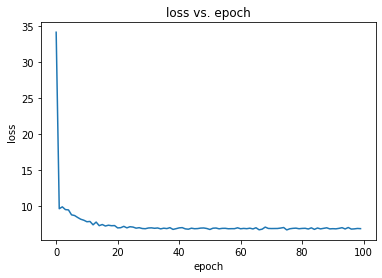

In [14]:
# determine posterior
names = ['logA', 'ns', 'H0', 'omegab', 'omegac']

#  length_eg = samples[:100]
train_chain = MCSamples(samples=length_eg[...,:5],names=names,labels=names)

n_params = len(train_chain.getParamNames().list())
dist = tfd.MultivariateNormalDiag(
    loc=np.zeros(n_params,dtype=np.float32), 
    scale_diag=np.ones(n_params,dtype=np.float32))

# make bijectors
bijectors = setup(2*n_params,n_params,True)

# train
trained_dist,bijector = train(dist,train_chain,bijectors=bijectors,batch_size=10,n_epochs=100)

In [15]:
# Compute the posterior at each sample:
posterior = trained_dist.log_prob(bijector.inverse(np.array(length_eg[...,:5],dtype=np.float32)))
print(len(posterior))

100


In [16]:
evidence = posterior - prior_lkl
mean = np.mean(evidence)
std = np.std(evidence)/np.sqrt(len(evidence))

print('evidence = {:.5f} +/- {:.5f}'.format(mean,std))

evidence = 353.30255 +/- 19.63783


In [18]:
#now lets just do this programatically:
# data arr
evidence = []
error = []

i=1
# do the calculations
for l in chain_lengths:
    print('length = {} \nRun {}/{}'.format(l,i,len(chain_lengths)))
    # prior + likelihood
    _samples = samples[:l]
    prior_lkl = np.array([lnprob(s) for s in _samples])
    
    #posterior
    train_chain = MCSamples(samples=_samples[...,:5],names=names,labels=names)

    n_params = len(train_chain.getParamNames().list())
    dist = tfd.MultivariateNormalDiag(
        loc=np.zeros(n_params,dtype=np.float32), 
        scale_diag=np.ones(n_params,dtype=np.float32))

    # make bijectors
    bijectors = setup(2*n_params,n_params,True,feedback=False)
    
    if( l < 500 ):
        batch_size = 10
    elif( l< 10000 ):
        batch_size = 100
    else:
        batch_size=1000

    # train
    trained_dist,bijector = train(dist,train_chain,bijectors=bijectors,batch_size=batch_size,n_epochs=100,feedback=False)
    
    posterior = trained_dist.log_prob(bijector.inverse(np.array(_samples[...,:5],dtype=np.float32)))
    
    e = posterior - prior_lkl
    while(np.mean(e) == np.inf):
        print('Mean evidence is infinite! Changing scale...')
        print('Scale = {}'.format(j))
        e = e/j
        j=j*10
        if( j>1e6 ):
            print('scale > 1000000. Stopping...')
            break
    if( j>1e6 ):
        break
    evidence.append(j*np.mean(e))
    error.append(j*np.std(e)/np.sqrt(len(evidence)))
    i+=1
    

length = 100 
Run 1/12
Removed no burn in
[####################] Completed!                             
length = 500 
Run 2/12
Removed no burn in
[####################] Completed!                             
length = 1000 
Run 3/12
Removed no burn in
[####################] Completed!                             
length = 5000 
Run 4/12
Removed no burn in
[####################] Completed!                             
length = 10000 
Run 5/12
Removed no burn in
[####################] Completed!                             
length = 20000 
Run 6/12
Removed no burn in
[####################] Completed!                             
length = 30000 
Run 7/12
Removed no burn in
[####################] Completed!                             
length = 40000 
Run 8/12
Removed no burn in
[####################] Completed!                             
length = 50000 
Run 9/12
Removed no burn in
[####################] Completed!                             
length = 75000 
Run 10/12
Removed no burn i

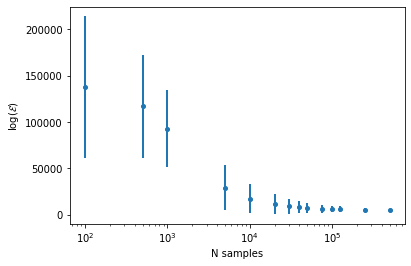

In [25]:
plt.errorbar(chain_lengths,evidence,yerr=error,lw=0,elinewidth=2,marker='o',markersize=4)

ax = plt.gca()
#ax.set_ylim([0.8, 2.0])
#ax.legend()
plt.xlabel('N samples')
plt.ylabel('$\log(\mathcal{E})$')
plt.xscale('log')

In [42]:
print(evidence)
print(error)

[137519.4656677246, 116893.34848022461, 92974.89973449707, 29339.005500793457, 17386.943996429443, 11264.112279891968, 9203.305894851685, 8130.229694366455, 7460.76117515564, 6642.313301086426, 6204.0947341918945, 5911.244409561157, 4935.211944580078, 4589.886225700378, 4386.337669372559]
[76420.50898742676, 55516.02015803738, 41544.42342270653, 23948.089992523193, 15941.836826553566, 10582.435760172959, 8079.254129137612, 6588.194096894547, 5582.461523691813, 4370.9787116673715, 3634.3915557666096, 3129.710259567734, 2142.694570713133, 1488.7938948377466, 1031.3043083239822]


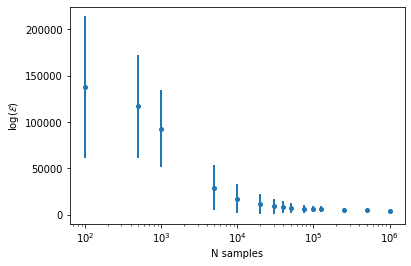

In [43]:
plt.errorbar(chain_lengths,evidence,yerr=error,lw=0,elinewidth=2,marker='o',markersize=4)

ax = plt.gca()
#ax.set_ylim([0.8, 2.0])
#ax.legend()
plt.xlabel('N samples')
plt.ylabel('$\log(\mathcal{E})$')
plt.xscale('log')

In [44]:
extra_lengths = [1000000]

In [45]:
i=1
# do the calculations
for l in extra_lengths:
    start_time = datetime.datetime.now()
    print('length = {} \nRun {}/{}'.format(l,i,len(extra_lengths)))
    # prior + likelihood
    _samples = samples[:l]
    prior_lkl = np.zeros(l)
    for idx in range(l):
        s = _samples[idx]
        prior_lkl[idx] = lnprob(s)
        if( idx % 10000 == 0 ):
            continue
        progress = int(idx/l*20)
        ret = '\r['
        for k in range(progress):
            ret += '#'
        for k in range(20-progress):
            ret += ' '
        print(ret+'] {}% ({})'.format(int(idx/l*100),(datetime.datetime.now() - start_time)// 1000000 * 1000000),end="")
    print('')
    #posterior
    train_chain = MCSamples(samples=_samples[...,:5],names=names,labels=names)

    n_params = len(train_chain.getParamNames().list())
    dist = tfd.MultivariateNormalDiag(
        loc=np.zeros(n_params,dtype=np.float32), 
        scale_diag=np.ones(n_params,dtype=np.float32))

    # make bijectors
    bijectors = setup(2*n_params,n_params,True,feedback=False)
    
    if( l < 500 ):
        batch_size = 10
    elif( l< 10000 ):
        batch_size = 100
    else:
        batch_size=10000

    # train
    trained_dist,bijector = train(dist,train_chain,bijectors=bijectors,batch_size=batch_size,n_epochs=100,feedback=False)
    
    posterior = trained_dist.log_prob(bijector.inverse(np.array(_samples[...,:5],dtype=np.float32)))
    
    e = posterior - prior_lkl
    while(np.mean(e) == np.inf):
        print('Mean evidence is infinite! Changing scale...')
        print('Scale = {}'.format(j))
        e = e/j
        j=j*10
        if( j>1e6 ):
            print('scale > 1000000. Stopping...')
            break
    if( j>1e6 ):
        break
    evidence.append(j*np.mean(e))
    error.append(j*np.std(e)/np.sqrt(len(evidence)))
    i+=1
    chain_lengths.append(l)
    

length = 1000000 
Run 1/1
[                    ] 0% (0:00:05)

KeyboardInterrupt: 

In [ ]:
#evidence = [137519.4656677246, 116893.34848022461, 92974.89973449707, 29339.005500793457, 17386.943996429443, 11264.112279891968, 9203.305894851685, 8130.229694366455, 7460.76117515564, 6642.313301086426, 6204.0947341918945, 5911.244409561157]
#error    = [76420.50898742676, 55516.02015803738, 41544.42342270653, 23948.089992523193, 15941.836826553566, 10582.435760172959, 8079.254129137612, 6588.194096894547, 5582.461523691813, 4370.9787116673715, 3634.3915557666096, 3129.710259567734]
